In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
import sncosmo
from itertools import cycle


import astropy.units as u
%matplotlib inline

In [2]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [3]:
import astropy
mycosmo = astropy.cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [4]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq','SN2006aa']
#OUTPUT
# - fitted_photometry
#  for each object (1) Table with fitted photometry @spctra MJD
#                  (2) high cadence fitted photometry 
#                  (3) plot of the fit in each band

color_dict = {'A':'grey',
              'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'grey',
                'swift_UVW2':'grey',
                'swift_UVM2':'grey',
                'swift_U':'grey',
                'swift_V':'grey',
                'swift_B':'grey'}


color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

In [5]:
import astropy
mycosmo = astropy.cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [6]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [7]:
def calc_lam_eff(wls, transmission, flux):
    return (integrate.trapz(transmission*flux*wls, wls)/\
            integrate.trapz(transmission*flux, wls))


def prop_err_div(x,y,sig_x,sig_y):
    return ((sig_x/y)**2  +  ((x*sig_y)/y**2)**2 )**0.5

In [8]:
convert2mjd = (lambda x: float(x.replace('_spec_extended.txt','').replace('_spec_extended_FL.txt','').replace('_spec_extended_SMOOTH.txt','')))

In [9]:
class ReMangle_SingleSpectrumClass():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, main_path, snname, twodim=True, spec_file=None, verbose=False):
        """
        """
        ## Initialise the class variables            
        self.main_path = main_path
        self.lc_data_path = main_path+'lc/'
        self.fitted_data_path = main_path+'lc/'
        self.spec_data_path = main_path+'spec/'
        self.snname = snname
        self.check_results_folder()
        self.extension_type='2dim' if twodim else 'classic'
        
        if spec_file is None:
            print ("Choose one spec_file from this list:")
            print (self.get_spec_list())
        else:
            self.spec_file = spec_file
            print ('self.spec_file', self.spec_file)
            self.load_manglingfile()
        self.load_final_info()

    def check_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/'%self.snname
        if not os.path.exists(results_directory):
            print ("I cant mangle a spectrum if I theres no fitted LC yet")
        else: self.results_mainpath = results_directory

    def check_extended_file(self):
        if self.extension_type == '2dim':
            mangled_file_path = self.main_path+'/results_template/%s/TwoDextended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        else:
            mangled_file_path = self.main_path+'/results_template/%s/extended_spectra/%s'%(self.snname,\
                                                                                      self.spec_file)
        if not os.path.isfile(mangled_file_path):
            print ("Sorry, This object %s has not mangled file"%mangled_file_path)
        else: 
            self.mangled_file_path = mangled_file_path

    def get_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended.txt' in f]
        return onlyfiles

    def check_spec_manglingphot(self):
        all_specs = self.get_spec_list()
        mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
        phot4mangling = pd.read_csv(mangling_file, sep='\t')
        for spec_file in all_specs:
            file_mjd = float(spec_file.replace('_spec_extended.txt',''))
            mask = phot4mangling['spec_mjd'].values == file_mjd
            if len(phot4mangling[mask])==0:
                print ('There.s no magnling photometry fro this. Are you sure nothing went wrong?', spec_file)
                print ('I compared', phot4mangling['spec_mjd'].values ,file_mjd)

    def get_FLAGGED_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_FL.txt' in f]
        return onlyfiles

    def get_SMOOTH_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SMOOTH.txt' in f]
        return onlyfiles


    def get_SNF_spec_list(self, verbose=False):
        if self.extension_type == '2dim':
            extended_files_path = self.main_path+'/results_template/%s/TwoDextended_spectra/'%(self.snname)
        else:
            extended_files_path = self.main_path+'/results_template/%s/extended_spectra/'%(self.snname)

        self.extended_files_path = extended_files_path
        onlyfiles = [f for f in os.listdir(extended_files_path) \
                         if os.path.isfile(os.path.join(extended_files_path, f)) if 'extended_SNF.txt' in f]
        return onlyfiles

    
    def load_original_phot(self, verbose = False):
        SNphotometry_PATH = os.path.join(self.main_path+\
                                         '/results_template/%s/fitted_phot_%s.dat'%(self.snname,self.snname))
        #lc_file = np.genfromtxt(SNphotometry_PATH, names=True, dtype=None,encoding="utf-8")
        lc_pd = pd.read_csv(SNphotometry_PATH, sep='\t')
        self.original_phot = lc_pd
        return lc_pd
    
    def load_manglingfile(self):
        if not hasattr(self, "results_mainpath"):
            self.check_results_folder()
        else:
            if (not 'FL.txt' in self.spec_file)&(not 'SNF.txt' in self.spec_file)&(not 'SMOOTH.txt' in self.spec_file):
                mangling_file = self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname
                phot4mangling = pd.read_csv(mangling_file, sep='\t')
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling['spec_mjd'].values == file_mjd
                self.phot4mangling = (phot4mangling[mask])
                if len(self.phot4mangling)<1:
                    raise Exception(""" ### ERROR: 
                    I looked in the file with the PHOTOMETRY for MANGLING 
                    (i.e. fitted_phot4mangling_SNNAME.dat).
                    I was loading the photometry to mangle/extend the spectrum you are currently loading
                    in the GRID. I found NO photometry for it... Maybe you should re run GP fit or check your list of spec.""")

                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
                
            elif 'SNF.txt' in self.spec_file: 
                phot4mangling = self.load_original_phot()
                file_mjd = float(self.spec_file.replace('_spec_extended_SNF.txt',''))
                
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']
            else: 
                phot4mangling = self.load_original_phot()
                file_mjd = convert2mjd(self.spec_file)
                mask = phot4mangling.index == np.argmin(np.abs(phot4mangling['MJD'].values - file_mjd))
                new_columns =[]
                for c in phot4mangling.columns:
                    if ('_err' not in c)&('MJD' not in c): new_columns.append(c+'_fitflux')
                    elif ('_err' in c): new_columns.append(c.replace('_err','')+'_fitfluxerr')
                    elif ('MJD' in c): new_columns.append('spec_mjd')
                phot4mangling.columns = new_columns 
                self.phot4mangling = phot4mangling[mask]
                self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                      if col[-8:]=='_fitflux']

    def load_extended_spec(self):
        if not hasattr(self, 'extended_files_path'):
            lista = self.get_spec_list()
        ext_spec = np.genfromtxt(self.extended_files_path+self.spec_file,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'fluxerr'])
        self.ext_spec = ext_spec
        return ext_spec
  
    def create_mangledspec_folder(self):
        mangledspec_directory = self.main_path+'/results_template/%s/RE_mangled_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(mangledspec_directory):
            os.makedirs(mangledspec_directory)
        self.mangledspec_path = mangledspec_directory
   
    def create_FINALspec_folder(self):
        FINAL_directory = self.main_path+'/results_template/%s/FINAL_spectra_%s/'%(self.snname, self.extension_type)
        if not os.path.exists(FINAL_directory):
            os.makedirs(FINAL_directory)
        if not os.path.exists(FINAL_directory+'/HostNotCorr/'):
            os.makedirs(FINAL_directory+'/HostNotCorr/')
            
        self.FINALspec_path = FINAL_directory

    def calculate_ratios4mangling(self, use_what_4phot=None):
        ratios=[]
        ratios_err=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        used_filters=[]
        
        outMJD_ratios=[]
        outMJD_ratios_err=[]
        outMJD_fitted_phot_list=[]
        outMJD_fitted_photerr_list=[]
        outMJD_wls_eff=[]
        outMJD_used_filters=[]
        for filt in self.avail_filters:
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values[0]
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values[0]
            
            if '%s_inrange'%filt in self.phot4mangling.columns: 
                inMJDrange_pnt = self.phot4mangling['%s_inrange'%filt].values[0]
            else: # this means the spectrum is synthesized from the 2dim surface
                inMJDrange_pnt = ~np.isnan(fitted_phot)

            lam_eff, raw_phot, raw_phot_err = self.band_flux(filt, use_what = use_what_4phot)

            if (not inMJDrange_pnt):
                outMJD_fitted_phot_list.append(fitted_phot)
                outMJD_fitted_photerr_list.append(fitted_phot_err)
                outMJD_ratios.append(fitted_phot/raw_phot)
                #outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                outMJD_ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, 0.) )
                outMJD_wls_eff.append(lam_eff)
                outMJD_used_filters.append(filt)
            else:
                fitted_phot_list.append(fitted_phot)
                fitted_photerr_list.append(fitted_phot_err)
                ratios.append(fitted_phot/raw_phot)
                #ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err, raw_phot_err) )
                ratios_err.append( prop_err_div(fitted_phot, raw_phot, fitted_phot_err , 0.) )
                wls_eff.append(lam_eff)
                used_filters.append(filt)
        #print ('ratios',len(ratios))
        ratios = np.array(ratios)
        wls_eff = np.array(wls_eff)
        ratios_err = np.array(ratios_err)
        used_filters = np.array(used_filters)
        outMJD_wls_eff = np.array(outMJD_wls_eff)
        outMJD_used_filters = np.array(outMJD_used_filters)

        
        self.fitted_phot_dict = {'eff_wls':wls_eff, 'fitted_phot':fitted_phot_list,\
                                     'fitted_phot_err':fitted_photerr_list, 'used_filters': used_filters}

        return ratios, ratios_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters

    def GP_interpolation_mangle(self, wls_eff, ratios, ratios_err, min_scale, optimization=True):
        if len(self.ext_spec['wls'])>10**4:
            # GP struggle to handle such a big number of points
            int_fraction = int(len(self.ext_spec['wls'])/5000.)
            print ('This spectrum has a huge amount of data points(%i), Im chopping a %i th of them'%(len(self.ext_spec['wls']), int_fraction))
            full_wls = self.ext_spec['wls'][::int_fraction]
        else:
            full_wls = self.ext_spec['wls']
        
        norm_wls = np.median(full_wls)
        full_wls_normed = full_wls/norm_wls
        wls_eff_normed = np.array(wls_eff)/norm_wls
            
        offset=1.
        norm = np.mean(ratios)
        ratios_normed = np.array(ratios)/norm-offset
        ratios_err_normed = np.array(ratios_err)/norm
        
        if len(ratios_normed)<1:
            return np.ones(len(full_wls_normed))*np.nan, np.ones(len(full_wls_normed))*np.nan
        else:
            def ll(p):
                #print (np.exp(p))
                if (np.exp(p)[1]<10**-2):#|(np.exp(p)[1]>10**5):
                    return np.inf
                else:
                    gp.set_parameter_vector(p)
                    return -gp.lnlikelihood(ratios_normed, quiet=False)#
            def grad_ll(p):
                gp.set_parameter_vector(p)
                return -gp.grad_lnlikelihood(ratios_normed, quiet=False)
            k= np.var(ratios_normed)*Matern32Kernel(0.5)
            wls_eff_normedT = np.atleast_2d(wls_eff_normed).T
            gp = george.GP(k)
            gp.compute(wls_eff_normedT, (ratios_err_normed))
            if optimization:
                try:
                    p0=gp.get_parameter_vector()
                    results = opt.minimize(ll, p0, jac=grad_ll)
                    print ('SCALE:',  '%.4f'%np.exp(results.x[1]))
                except:
                    pass
                    print ('*** GP optimization failed ***'*10)
            #print ('results', np.exp(results.x))
            mu, cov = gp.predict(ratios_normed, full_wls_normed)
            std = np.sqrt(np.diag(cov))
                
            if len(self.ext_spec['wls'])>10**4:
                # GP struggle to handle such a big number of points
                mu_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], mu)
                std_full = np.interp(self.ext_spec['wls'], self.ext_spec['wls'][::int_fraction], std)
            else:
                mu_full = mu
                std_full = std
            return norm*(mu_full+offset), np.abs(norm*(std_full))


    def band_flux(self, filter_name, use_what='ext_spectrum'):
        if use_what == 'ext_spectrum':
            spec_flux = self.ext_spec
            #print ('Im using the UNmangled one')
        else:
            spec_flux = self.mangled_spec[use_what]
            #print ('Im using the %s-TIME mangled one'%use_what)

        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])

        cut_spec = [(spec_flux['wls']>min(filt_transm['wls']))&\
                     (spec_flux['wls']<max(filt_transm['wls']))]
        cut_ext_spec = spec_flux[cut_spec].copy()
        
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], 
                                                       filt_transm['flux'], 
                                                       kind='linear')
        filt_transm_interp = filt_transm_interp_func(cut_ext_spec['wls'])
        filt_transm_interp_xLambda = filt_transm_interp*cut_ext_spec['wls']
        
        lam_eff = calc_lam_eff(cut_ext_spec['wls'], 
                                        filt_transm_interp, 
                                        cut_ext_spec['flux']) 

        raw_phot = integrate.trapz(filt_transm_interp_xLambda*cut_ext_spec['flux'], cut_ext_spec['wls'])/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_ext_spec['wls'])
            
        raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_ext_spec['fluxerr'])**2, 
                                        cut_ext_spec['wls']))**0.5/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_ext_spec['wls'])
        if use_what == 'ext_spectrum': 
            return lam_eff, raw_phot, raw_phot_err
        else: 
            return lam_eff, raw_phot, raw_phot_err

    def mangle_iteration_function(self):
        if ('FL' in self.spec_file):
            min_scale=0.5
            optimization=False
        else:
            min_scale=5*10**-3
            optimization=True
        
        # 1st iteration        
        ratios_0, ratios_0_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
            self.calculate_ratios4mangling(use_what_4phot='ext_spectrum')
        mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_0, 
                                                                ratios_0_err, min_scale, 
                                                                optimization=optimization)

        mangled_spec = self.ext_spec['flux'] * mang_mask
        mangled_spec_err = ((self.ext_spec['flux'] * mang_mask_err)**2)**0.5

        self.mangled_spec = {0 : np.array([a for a in zip(self.ext_spec['wls'],
                                                            mangled_spec, mangled_spec_err)],
                                     dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])}
        self.mangling_mask = {0 : (mang_mask, mang_mask_err) }
        
        mangled_phot_list=[]
        for filt in used_filters:
            mangled_phot_list.append(self.band_flux(filt, use_what=0)[1])
        self.magled_photometry_dict = {0 : {'eff_wls': wls_eff, 
                                              'fitted_phot': mangled_phot_list,\
                                           'used_filters': used_filters}}

        # More iterations
        ratios = ratios_0
        max_iteration = 5
        for i in range(max_iteration):
            if max(np.abs(ratios-1.))>0.05:
                #print (i)
                ratios_iter, ratios_iter_err, wls_eff, used_filters, outMJD_wls_eff, outMJD_used_filters =\
                    self.calculate_ratios4mangling(use_what_4phot=(i))
                mang_mask, mang_mask_err = self.GP_interpolation_mangle(wls_eff, ratios_iter, 
                                                                            ratios_iter_err, min_scale, 
                                                                        optimization=optimization)
                #print ('iteration', i,ratios_iter)
                mangled_spec = self.mangled_spec[i]['flux'] * mang_mask
                #mangled_spec_err = ( (self.mangled_spec[str(i+1)]['flux'] * mang_mask_err)**2 +\
                #            (self.mangled_spec[str(i+1)]['fluxerr'] * mang_mask)**2 )**0.5
                mangled_spec_err = (self.mangled_spec[i]['flux'] * mang_mask_err)

                #print ('save new', (i+1))
                self.mangled_spec[i+1] = np.array([a for a in zip(self.ext_spec['wls'], 
                                                                       mangled_spec, mangled_spec_err)],
                                         dtype=[('wls', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8')])
                
                self.mangling_mask[i+1] = (mang_mask, mang_mask_err)
                mangled_phot_list=[]
                for filt in used_filters:
                    mangled_phot_list.append(self.band_flux(filt, use_what=i+1)[1])
                self.magled_photometry_dict[i+1] = {'eff_wls': wls_eff, 'fitted_phot': mangled_phot_list,\
                                                       'used_filters': used_filters}
                ratios = np.copy(ratios_iter)
            else:
                pass
        self.mangling_mask_FINAL = mangled_spec/self.ext_spec['flux']
        iters_list = list(self.mangled_spec.keys())
        last_iter = iters_list[0]#[-1]
        #print ('last_iter', last_iter)
        self.final_mangled_spec = self.mangled_spec[last_iter]
        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]

        fig=plt.figure(1, figsize=(10,6))
        ax1 = plt.subplot2grid((3,1), (0,0))
        for f,w,r,rerr in zip(used_filters, wls_eff,\
                              ratios_0, ratios_0_err):
            ax1.errorbar(w, r, yerr=rerr, marker='o', mfc= color_dict[f], mec=color_dict[f], linestyle='None',\
                     ecolor= color_dict[f], label='%s'%f)
        #print (iters_list)
        for it in (iters_list):
            mask, mask_err = self.mangling_mask[it]
            ax1.errorbar(self.ext_spec['wls'], mask, color='orange', lw=0.3, alpha=0.5)
            ax1.fill_between(self.ext_spec['wls'], mask-mask_err, mask+mask_err, 
                             color='orange',alpha=0.3)
        ax1.errorbar(self.ext_spec['wls'], self.mangling_mask_FINAL, 
                     color='red', linestyle=':', lw=1.5, alpha=0.9)
        ax1.fill_between(self.ext_spec['wls'], self.mangling_mask_FINAL-mask_err, self.mangling_mask_FINAL+mask_err,
                     facecolor='red', alpha=0.5)

        ax1.set_ylabel('Phot from LCfitting /\n Phot from Raw Spec')
        ax1.set_xlabel('Effective Wavelenght')
        ax1.set_title('%s: Mangled spectrum %s'%(self.snname, self.spec_file))
        ax1.set_xlim(1600., 10500.)
        ax1.legend(ncol=5, fontsize=6)
        
        ax2 = plt.subplot2grid((3,1), (1,0), rowspan=2)
        if ('FL' in self.spec_file)|('SNF' in self.spec_file):
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', linestyle='--', label='Mangled_Spec FAKE SPEC')
        else:
            ax2.errorbar(self.mangled_spec[last_iter]['wls'], self.mangled_spec[last_iter]['flux'],\
                     lw=0.7, color='k', label='Mangled_Spec')

        ax2.errorbar(self.ext_spec['wls'], self.ext_spec['flux'],\
                     lw=0.7, color='r', label='Raw Spec')
        ax2.errorbar(self.fitted_phot_dict['eff_wls'], self.fitted_phot_dict['fitted_phot'],\
                     yerr=self.fitted_phot_dict['fitted_phot_err'], marker='o',
                     linestyle='None', label='Fitted Phot')
        ax2.errorbar(self.magled_photometry_dict[last_iter]['eff_wls'],
                     self.magled_photometry_dict[last_iter]['fitted_phot'],\
                     marker='^', mfc='r', mec='r', linestyle='None', label='Phot from mangled spec')
        ax2.plot(self.magled_photometry_dict[iters_list[-1]]['eff_wls'], 
                 self.magled_photometry_dict[iters_list[-1]]['fitted_phot'],\
                 marker='.', mfc='r', mec = 'None', linestyle='None')
    
        ax2.fill_between(self.mangled_spec[last_iter]['wls'], 
                         self.mangled_spec[last_iter]['flux']-self.mangled_spec[last_iter]['fluxerr'],\
                         self.mangled_spec[last_iter]['flux']+self.mangled_spec[last_iter]['fluxerr'], 
                         color='grey',alpha=0.3)
        ax2.set_ylabel('Flux erg s-1 cm-2 A-1')
        ax2.set_xlabel('Wavelenght')
        ax2.set_xlim(1600., 10500.)
        ax2.legend()
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        if 'FL' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.png'),
                        bbox_inches='tight')
        elif 'SNF' in self.spec_file:
            fig.savefig(self.mangledspec_path+self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.pdf'),
                        bbox_inches='tight')
        else:
            fig.savefig(self.mangledspec_path+'%.2f_REmangled_spec.png'%spec_number, bbox_inches='tight')

        plt.close(fig)
        
        self.save_mangled_spectrum()
        return list(self.mangled_spec.keys())

        
    def get_diff_FittedMangled_phot(self):
        fitted_phot = np.array(self.fitted_phot_dict['fitted_phot'])
        fitted_phot_err = np.array(self.fitted_phot_dict['fitted_phot_err'])
        mangled_phot = np.array(self.magled_photometry_dict['fitted_phot'])
        diff_mag = -2.5*np.log10(mangled_phot/fitted_phot)
        
        def err_fromFlux_toMag(flux, err_flux):
            flux = np.array(flux, dtype=float)
            err_flux = np.array(err_flux, dtype=float)
            return 2.5/np.log(10.) * err_flux/flux
    
        fitted_phot_err_mag = err_fromFlux_toMag(fitted_phot, fitted_phot_err)
        discrepancy_mag = diff_mag/fitted_phot_err_mag
        return self.magled_photometry_dict['used_filters'], diff_mag, discrepancy_mag 

    def get_filter_transmission(self, f):
        filt_transm = np.genfromtxt(self.main_path+'filters/%s.dat'%f,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        return filt_transm

    def save_mangled_spectrum(self):

        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you have to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'mangledspec_path')):
            self.create_mangledspec_folder()
        
        save_path = self.mangledspec_path

        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        if 'FL' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_FL.txt','_REmangled_spec_FL.txt'), 'w')
        elif 'SMOOTH' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SMOOTH.txt','_REmangled_spec_SMOOTH.txt'), 'w')
        elif 'SNF' in self.spec_file:
            fout = open(self.mangledspec_path+\
                        self.spec_file.replace('_spec_extended_SNF.txt','_REmangled_spec_SNF.txt'), 'w')
        else:
            fout = open(self.mangledspec_path+'/%.2f_REmangled_spec.txt'%spec_number, 'w')

        fout.write('#wls\tflux\tfluxerr\n')
        for w,f,ferr in zip(self.ext_spec['wls'], self.final_mangled_spec['flux'], self.final_mangled_spec['fluxerr']):
            fout.write('%E\t%E\t%E\n'%(w,f,ferr))
        fout.close() 
        
        
    def load_final_info(self):
        final_info_table = pd.read_csv(self.main_path+'/info/FINAL_info.dat')
        mask = final_info_table.Name==self.snname
        if len(final_info_table[mask])==0:
            raise Exception((' !!!!!!!!!!!!! \n I CANT FIND THIS OBJECT IN THE FINAL_info.dat FILE!! \n Add it to the PYCOCO/info/FINAL_info.dat first.'))
        return (final_info_table[mask])
        
        
    def save_FINAL_spectrum(self):
        if (not hasattr(self, 'final_mangled_spec')):
            print ("Mangled spectrum not available. First you need to mangle the spectrum calling self.mangle_spectrum()")
        if (not hasattr(self, 'FINALspec_path')):
            self.create_FINALspec_folder()

        flux = self.final_mangled_spec['flux']
        fluxerr = self.final_mangled_spec['fluxerr']
        
        sn_info = self.load_final_info()
        MWdust = sncosmo.CCM89Dust()
        Hostdust = sncosmo.CCM89Dust()
        r_v = 3.1
        z = sn_info['z'].values[0]
        
        wls = self.ext_spec['wls']
        wls_restframe = self.ext_spec['wls']/(1+z)
        
        # Host corrections in SN restframe
        Host_ebv = sn_info['Host ebv'].values[0]
        if 'ddag' in Host_ebv: Host_ebv = float(Host_ebv.replace('ddag','')) 
        Hostdust.parameters = [Host_ebv, r_v]
        Host_extinction_perc = Hostdust.propagate(wls_restframe, np.ones(len(flux)))
        #mask_bump = [~((wls_restframe>1650)&(wls_restframe<3000))]
        #Host_extinction_perc_cut = (Host_extinction_perc[mask_bump])
        #wls_cut = (wls_restframe[mask_bump])
        #Host_extinction_perc_withoutBump = \
        #        np.interp(wls_restframe, wls_cut, Host_extinction_perc_cut)

        #plt.plot(wls_restframe, Host_extinction_perc)
        #plt.plot(wls_cut, Host_extinction_perc_cut, ':')
        #plt.plot(wls_restframe, Host_extinction_perc_withoutBump, '--')

        # MW corrections in Obs restframe
        #MW_ebv = sn_info['MW ebv'].values[0]
        #MWdust.parameters = [MW_ebv, r_v]
        #MW_extinction_perc = MWdust.propagate(wls, np.ones(len(flux)))
        #mask_bump = [~((wls>1650)&(wls<3000))]
        #MW_extinction_perc_cut = (MW_extinction_perc)[mask_bump]
        #wls_cut = (wls)[mask_bump]
        #MW_extinction_perc_withoutBump = \
        #        np.interp(wls_restframe, wls_cut, MW_extinction_perc_cut)
            
        dist = 10**(mycosmo.distmod(z).value/5.+1)
        To_abs_lum = (dist/10)**2

        self.final_spec_wls = wls_restframe
        self.HostCorr_spec_flux = To_abs_lum*flux
        self.HostCorr_spec_fluxerr = To_abs_lum*fluxerr

        self.HostNOTCorr_spec_flux = To_abs_lum*flux*Host_extinction_perc
        self.HostNOTCorr_spec_fluxerr = To_abs_lum*fluxerr*Host_extinction_perc
        spec_number = self.phot4mangling.spec_mjd.values[0]#self.phot4mangling.index.values[0]
        
        for path_fold in ['', '/HostNotCorr/']:
            path = self.FINALspec_path + path_fold
            if 'FL' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_FL.txt','_FINAL_spec_FL.txt'), 'w')
            elif 'SMOOTH' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SMOOTH.txt','_FINAL_spec_SMOOTH.txt'), 'w')
            elif 'SNF' in self.spec_file:
                fout = open(path+self.spec_file.replace('_spec_extended_SNF.txt','_FINAL_spec_SNF.txt'), 'w')
            else:
                fout = open(path+'/%.2f_FINAL_spec.txt'%spec_number, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            if path_fold=='':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostCorr_spec_flux, 
                                self.HostCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 
            elif path_fold=='/HostNotCorr/':
                for w,f,ferr in zip(self.final_spec_wls, 
                                self.HostNOTCorr_spec_flux, 
                                self.HostNOTCorr_spec_fluxerr):
                    fout.write('%E\t%E\t%E\n'%(w,f,ferr))
                fout.close() 



In [10]:
SN_lista_II = ['SN2013by','SN2014G','ASASSN15oz','SN2007od','SN2013ej','SN2013fs','SN2008bj',
'SN2016X','SN2013ab','SN2009bw','SN2012aw','SN2008in','SN2004et','SN2009dd',
'SN1999em','SN2009kr','ASASSN14jb','SN2012A','SN2009ib','SN2013am','SN2016bkv','SN2009N',
'SN2005cs', 'SN2008fq', 'SN2007pk', 'SN2010al', 'SN2009ip', 'SN2006aa', 'SN2011ht','SN2013bynouv']

SN_lista_Ib = ['SN1993J', 'SN2006T', 'SN2008aq', 'SN2008ax', 'SN2008bo', 'SN2011dh', 'SN2011ei', 
               'SN2011fu', 'SN2011hs', 'SN2013df','SN2016gkg', 'SN1999dn', 'SN2004gq', 'SN2004gv', 'SN2005bf',
               'SN2005hg', 'SN2006ep',  'SN2007Y', 'SN2007uy',  'SN2008D', 'SN2009iz',
               'SN2009jf', 'SN2012au','iPTF13bvn', 'SN1994I','SN2004aw','SN2004fe',
               'SN2004gt','SN2007gr','SN2011bm','SN2013ge','SN1998bw','SN2002ap','SN2006aj',
               'SN2007ru','SN2009bb', 'SN2012ap']

sn_type_lista = [('ASASSN14jb', 'II'),
 ('ASASSN15oz', 'II'),
 ('SN1993J', 'IIb'),
 ('SN1994I', 'Ic'),
 ('SN1998bw', 'Ic-BL'),
 ('SN1999dn', 'Ib'),
 ('SN1999em', 'II'),
 ('SN2002ap', 'Ic-BL'),
 ('SN2004aw', 'Ic'),
 ('SN2004et', 'II'),
 ('SN2004fe', 'Ic'),
 ('SN2004gq', 'Ib'),
 ('SN2004gt', 'Ic'),
 ('SN2004gv', 'Ib'),
 ('SN2005bf', 'Ib'),
 ('SN2005cs', 'II'),
 ('SN2005hg', 'Ib'),
 ('SN2006T', 'IIb'),
 ('SN2006aa', 'IIn'),
 ('SN2006aj', 'Ic-BL'),
 ('SN2006ep', 'Ib'),
 ('SN2007Y', 'Ib'),
 ('SN2007gr', 'Ic'),
 ('SN2007od', 'II'),
 ('SN2007pk', 'IIn'),
 ('SN2007ru', 'Ic-BL'),
 ('SN2007uy', 'Ib'),
 ('SN2008D', 'Ib'),
 ('SN2008aq', 'IIb'),
 ('SN2008ax', 'IIb'),
 ('SN2008bj', 'II'),
 ('SN2008bo', 'IIb'),
 ('SN2008fq', 'IIn'),
 ('SN2008in', 'II'),
 ('SN2009N', 'II'),
 ('SN2009bb', 'Ic-BL'),
 ('SN2009bw', 'II'),
 ('SN2009dd', 'II'),
 ('SN2009ib', 'II'),
 ('SN2009ip', 'IIn'),
 ('SN2009iz', 'Ib'),
 ('SN2009jf', 'Ib'),
 ('SN2009kr', 'II'),
 ('SN2010al', 'IIn'),
 ('SN2011bm', 'Ic'),
 ('SN2011dh', 'IIb'),
 ('SN2011ei', 'IIb'),
 ('SN2011fu', 'IIb'),
 ('SN2011hs', 'IIb'),
 ('SN2011ht', 'IIn'),
 ('SN2012A', 'II'),
 ('SN2012ap', 'Ic-BL'),
 ('SN2012au', 'Ib'),
 ('SN2012aw', 'II'),
 ('SN2013ab', 'II'),
 ('SN2013am', 'II'),
 ('SN2013by', 'II'),
 ('SN2013df', 'IIb'),
 ('SN2013ej', 'II'),
 ('SN2013fs', 'II'),
 ('SN2013ge', 'Ic'),
 ('SN2014G', 'II'),
 ('SN2016X', 'II'),
 ('SN2016bkv', 'II'),
 ('SN2016gkg', 'IIb'),
 ('iPTF13bvn', 'Ib'),
 ('SN2013bynouv', 'II')]

In [11]:

sn_type_lista=  [
 ('SN2011ht', 'IIn')]



Choose one spec_file from this list:
['55887.65_spec_extended.txt', '55929.70_spec_extended.txt', '55949.41_spec_extended.txt', '55970.27_spec_extended.txt', '55986.81_spec_extended.txt', '55988.62_spec_extended.txt']
55887.65_spec_extended.txt
self.spec_file 55887.65_spec_extended.txt
SCALE: 0.0108
SCALE: 5.1852
SCALE: 5.6405
SCALE: 6.1155
SCALE: 6.6068
SCALE: 7.2641
55929.70_spec_extended.txt
self.spec_file 55929.70_spec_extended.txt
SCALE: 0.3747
SCALE: 42800189.2086
SCALE: 42800192.8647
SCALE: 42800196.5206
SCALE: 42800200.1766
SCALE: 42800203.8326
55949.41_spec_extended.txt
self.spec_file 55949.41_spec_extended.txt
SCALE: 39265217.3442
SCALE: 39265217.6664
SCALE: 39265217.9888
SCALE: 39265218.3113
SCALE: 39265218.6336
SCALE: 39265218.9560
55970.27_spec_extended.txt
self.spec_file 55970.27_spec_extended.txt
SCALE: 0.4925
SCALE: 0.4925
SCALE: 0.4925
SCALE: 0.4925
SCALE: 0.4925
SCALE: 0.4925
55986.81_spec_extended.txt
self.spec_file 55986.81_spec_extended.txt
SCALE: 0.3355
SCALE: 0.3

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


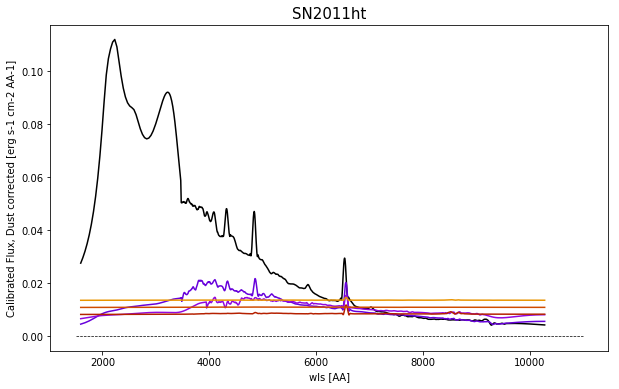

In [13]:
for snname,type_ in sn_type_lista:
    new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=snname, twodim=True,\
                        spec_file=None, verbose=True)
    for a in new_spec.get_spec_list()[:]:
        print (a)
        new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=new_spec.snname, twodim=True,\
                            spec_file=a, verbose=False)
        new_spec.load_extended_spec()
        result = new_spec.mangle_iteration_function()
        new_spec.save_FINAL_spectrum()
        
    color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_spec_list())*1.2)))
    fig= plt.figure(1, figsize=(10,6))
    plt.title(new_spec.snname, fontsize=15)
    mean=1.; a=0
    for l in new_spec.get_spec_list()[:]:
        sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
        plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
        if mean==1.:
            mean = np.median(sp[:,1])*0.2
        a=a+1
        
    plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
    plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
    plt.xlabel('wls [AA]')
    fig.savefig(new_spec.FINALspec_path+'Final_Spec.png', bbox_inches='tight')
    plt.show()
    plt.close()

SN2011ht
Choose one spec_file from this list:
['55887.65_spec_extended.txt', '55929.70_spec_extended.txt', '55949.41_spec_extended.txt', '55970.27_spec_extended.txt', '55986.81_spec_extended.txt', '55988.62_spec_extended.txt']
self.spec_file 55843.70_spec_extended_FL.txt
self.spec_file 55845.70_spec_extended_FL.txt
self.spec_file 55847.69_spec_extended_FL.txt
self.spec_file 55849.69_spec_extended_FL.txt
self.spec_file 55851.69_spec_extended_FL.txt
self.spec_file 55853.69_spec_extended_FL.txt
self.spec_file 55855.68_spec_extended_FL.txt
self.spec_file 55857.68_spec_extended_FL.txt
self.spec_file 55859.68_spec_extended_FL.txt
self.spec_file 55861.68_spec_extended_FL.txt
self.spec_file 55863.68_spec_extended_FL.txt
self.spec_file 55865.67_spec_extended_FL.txt
self.spec_file 55867.67_spec_extended_FL.txt
self.spec_file 55869.67_spec_extended_FL.txt
self.spec_file 55871.67_spec_extended_FL.txt
self.spec_file 55873.67_spec_extended_FL.txt
self.spec_file 55875.66_spec_extended_FL.txt
self.spe

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


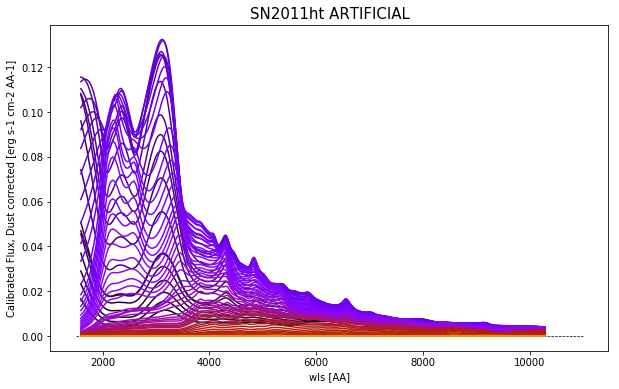

In [14]:
# SN 2013ab had some problems!!!!!

for sn,type_ in sn_type_lista[:]:
    print (sn)
    new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                        spec_file=None, verbose=True)
    for f in new_spec.get_FLAGGED_spec_list():
        new_spec= ReMangle_SingleSpectrumClass(main_path=DATALC_PATH, snname=sn, twodim=True,\
                    spec_file=f, verbose=True)

        new_spec.load_extended_spec()
        result = new_spec.mangle_iteration_function()
        new_spec.save_FINAL_spectrum()
    new_spec.create_FINALspec_folder()
    color=cycle(plt.cm.gnuplot(np.linspace(0,1,len(new_spec.get_FLAGGED_spec_list())*1.2)))
    fig= plt.figure(1, figsize=(10,6))
    plt.title(sn+' ARTIFICIAL', fontsize=15)
    mean=1.; a=0
    for l in new_spec.get_FLAGGED_spec_list()[:]:
        sp = np.genfromtxt(new_spec.FINALspec_path+l.replace('spec_extended', 'FINAL_spec'))
        plt.plot(sp[:,0], sp[:,1]+mean*a, lw=1.5,color=next(color))
        if mean==1.:
            mean = np.median(sp[:,1])*0.2
        
    plt.hlines(0, 1500, 11000, lw=0.7, linestyle='--')
    plt.ylabel('Calibrated Flux, Dust corrected [erg s-1 cm-2 AA-1]')
    plt.xlabel('wls [AA]')
    fig.savefig(new_spec.FINALspec_path+'Final_Spec_FL.png', bbox_inches='tight')
    plt.show()
    plt.close()